<p style="background-color:#00A2BB; font-family: sans-serif; color:#FFFFFF; font-size:200%; text-align:center; text-transform: uppercase"><b>Redes nuronales LSTM para la detección de Fake News</b></p>

Utilizaremos un conjunto de datos con textos clasificados como Fake news o no. Para ello exploraremos el conjunto de datos con el que vamos a trabajar, realizaremos graficas, un pre-procesado, y una posteriormente aplicaremos métodos de analisis de texto, y aplicaremos un algoritmo de machin learning. 

El proceso de apertura de los datos y exloracion lo haremos utilizando las clases que hemos creado para ello. Estas se encuentran en distintos scripts del proyecto, los importaremos y aplicaremos a nuestro conjunto de datos. 

**Nota**: las graficas se han realizado con plotly, esta libreria uliza javascript. Para que las graficas sean visibles en la previsualizacion del notebook en el repositorio GitHub las guardaremos y abriremos, luego las graficas apareceran repetidas en este documento. Además se ha subido a Plotly Charts, donde se genera un link y se han agrupado en un dashboard al que se puede acceder en el siguiente link:

https://chart-studio.plotly.com/dashboard/egctechspace:71

---

<p style="font-family: sans-serif; color:#00A2BB; font-size:150%; text-align:left; text-transform: uppercase"><b>1. Importar dependencias</b></p>

In [1]:
# Importar dependencias
import os    # Define rutas relativas
import sys   # Permite importar modulos que se encuentran en otro directorio

import pandas as pd
import numpy as np
import random

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.wrappers.scikit_learn import KerasClassifier

from keras.metrics import Precision, Recall

import configparser

import chart_studio
import chart_studio.plotly as py
from IPython.display import Image

In [2]:
# Ruta relativa del proyecto
PROJECT_PATH = os.path.dirname(os.getcwd())
sys.path.insert(0, PROJECT_PATH)
IMAGES_PATH = os.path.join(PROJECT_PATH, 'assets', 'images', 'fake_news')

In [3]:
# Importamos modulos creados con funciones para analisis, pre-procesado y procesado de texto 
from modules.data_explorer import FileOpener, ExploredData, Graphics
from modules.text_preproccesing import TextPreProccessing, ExploreTexts
from modules.text_proccesing import Tokenize, Embeddings

In [4]:
# Fijamos semilla para poder reproducir los resultados
SEED = 19

np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

In [5]:
# Leer credentialts.ini
config = configparser.ConfigParser()
config.read("credentials.ini")

['credentials.ini']

In [6]:
# Configura credenciales de Chart Studio
USERNAME = config["plotly"]["USERNAME"]
API_KEY = config["plotly"]["API_KEY"]
chart_studio.tools.set_credentials_file(username = USERNAME, api_key = API_KEY)

In [7]:
def save_chart(fig, file_name, upload=True, ext=".png", base_path="."):
    # Función para almacenar gráficas
    if upload:
        try:
            plot_url = py.plot(fig, filename=file_name, fileopt='overwrite')
            print(plot_url)
        except Exception as e:
            print(f"El grafico no se ha podido subir a Chart Studio: {e}")
            
    # Construye la ruta completa al archivo de imagen
    image_path = os.path.join(base_path, f'{file_name}{ext}')
    
    # Guarda la figura en el archivo especificado
    fig.write_image(image_path)
    
    # Muestra la imagen en el cuaderno Jupyter
    return Image(filename=image_path)


<p style="font-family: sans-serif; color:#00A2BB; font-size:150%; text-align:left; text-transform: uppercase"><b>2. Cargar datos</b></p>

In [8]:
RELATIVE_PATH_FILE = "data/raws/test.csv"                          # Ruta del archivo 
PATH_FILE = os.path.join(PROJECT_PATH, RELATIVE_PATH_FILE)

In [9]:
RELATIVE_PATH_GLOVE_FILE = "data/raws/glove.6B.50d.txt"            # Ruta del archivo de embedding 
PATH_GLOVE_FILE = os.path.join(PROJECT_PATH, RELATIVE_PATH_GLOVE_FILE)

In [10]:
# Apertura de los datos
df = FileOpener(PATH_FILE).get_df()
df.head(5)

Unnamed: 0                                              title  \
0        8476                       You Can Smell Hillary’s Fear   
1       10294  Watch The Exact Moment Paul Ryan Committed Pol...   
2        3608        Kerry to go to Paris in gesture of sympathy   
3       10142  Bernie supporters on Twitter erupt in anger ag...   
4         875   The Battle of New York: Why This Primary Matters   

                                                text label  
0  Daniel Greenfield, a Shillman Journalism Fello...  FAKE  
1  Google Pinterest Digg Linkedin Reddit Stumbleu...  FAKE  
2  U.S. Secretary of State John F. Kerry said Mon...  REAL  
3  — Kaydee King (@KaydeeKing) November 9, 2016 T...  FAKE  
4  It's primary day in New York and front-runners...  REAL

<p style="font-family: sans-serif; color:#00A2BB; font-size:150%; text-align:left; text-transform: uppercase"><b>3. Explorar de datos</b></p>

In [11]:
# Ejecutar clase ExploreData del modulo importado data_explorer para obtener información de los datos 
explorator = ExploredData(df)

- **Información básica**

Consultamos información básica, como forma del conjunto de datos; tipo, valores unicos y nulos por columnas.

In [12]:
# Informacion basica del conjunto de datos 
explorator.info_DataSet()

Forma datos 
 - Filas: 6335 
 - Columnas: 4


Conteo    Tipo  Nulos  Valores unicos
Unnamed: 0    6335   int64      0            6335
title         6335  object      0            6256
text          6335  object      0            6060
label         6335  object      0               2

- **Elección de columnas de interés**. 

En particular analizaremos el texto del título de la noticia para reducir tiempos de ejecución, ya que el conjunto de texto de la noticia consumirá muchos recursos, y la variable dependiente a clasidicar, la columna `label`. 

In [13]:
# Eliminar columnas no necesarias
columns_to_drop = ["Unnamed: 0", "text"]
df = explorator.drop_columns_by_name(columns_to_drop)

- **Clases**

Contamos y representamos el numero de clases a clasificar. 

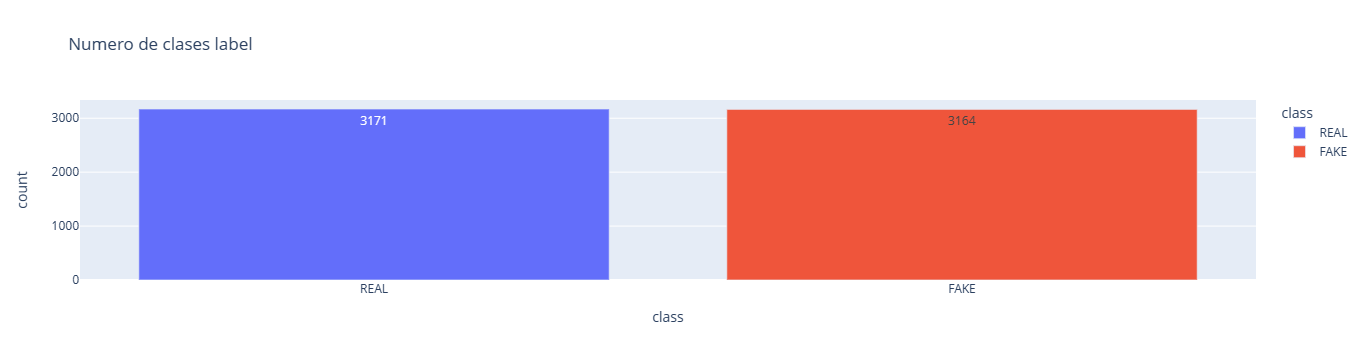

In [14]:
# Conteo de valores por cada clase
count_label = explorator.count_var("label")
# Representacion 
grapher = Graphics(count_label)
bar_graph_label = grapher.plot_bar(X = "class", Y = "count", title = "Numero de clases label", decimals = ".4", color_var = "class")
bar_graph_label.show()

https://plotly.com/~egctechspace/68/


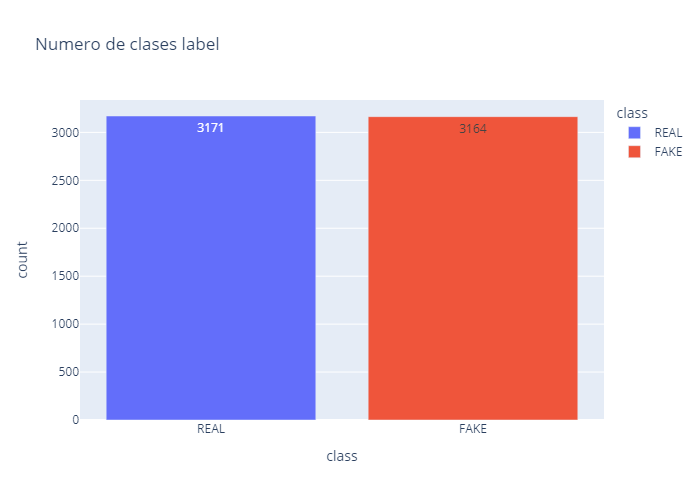

In [15]:
# Sube la figura a Chart Studio y la guarda 
save_chart(bar_graph_label, "class_label", upload=True, ext=".png", base_path=IMAGES_PATH)

Vemos que se trata un problema de clasificación de dos clases que se puede combertir a clasificación binaria: 
- Fake:0
- Real:1

In [16]:
# Comvertir clases en valores numericos Fake:0, Real:1
df = explorator.LabelEncoder_class("label", "label_encoder")

In [17]:
# Muestra datos obtenidos
df.head()

title label  label_encoder
0                       You Can Smell Hillary’s Fear  FAKE              0
1  Watch The Exact Moment Paul Ryan Committed Pol...  FAKE              0
2        Kerry to go to Paris in gesture of sympathy  REAL              1
3  Bernie supporters on Twitter erupt in anger ag...  FAKE              0
4   The Battle of New York: Why This Primary Matters  REAL              1

<p style="font-family: sans-serif; color:#00A2BB; font-size:150%; text-align:left; text-transform: uppercase"><b>4. Pre-procesado</b></p>

In [18]:
# Definimos variables a utilizar en el notebook
TEXT_COLUMN = "title"
CLEAN_TEXT = "cleaned_text"
CLASS = "label_encoder"

- **Limpieza del texto**

Eliminación del texto de palabras, signos, numeros, ect que no aportan información relevante como pueden ser conectores como "and" que no aportan información relevante y son frecuentes en los textos.  Además se aplican téxnicas la lematización del texto para obtener los lemas, por ejemplo de runing obtendriamos run. 

In [19]:
# Clase de limpieza de texto a cada elemento de la columna con el texto
df[CLEAN_TEXT] = df[TEXT_COLUMN].apply(lambda x: TextPreProccessing(x).clean_text())

In [20]:
# Mostramos los datos
df.head()

title label  label_encoder  \
0                       You Can Smell Hillary’s Fear  FAKE              0   
1  Watch The Exact Moment Paul Ryan Committed Pol...  FAKE              0   
2        Kerry to go to Paris in gesture of sympathy  REAL              1   
3  Bernie supporters on Twitter erupt in anger ag...  FAKE              0   
4   The Battle of New York: Why This Primary Matters  REAL              1   

                                        cleaned_text  
0                                 smell hillary fear  
1  watch exact moment paul ryan commit political ...  
2                       kerry paris gesture sympathy  
3  bernie supporters twitter erupt anger dnc try ...  
4                     battle new york primary matter

- **Visualización texto limpio**. 

Se visualiza en una nube de palabras `wordcloud` las palabras que aparecen en el texto donde el tamaño de las palabras indica la frecuencia de aparición. 

In [21]:
# Ejecutamos el explorador del texto creado para nuestro conjunto de datos
text_explorer = ExploreTexts(df)

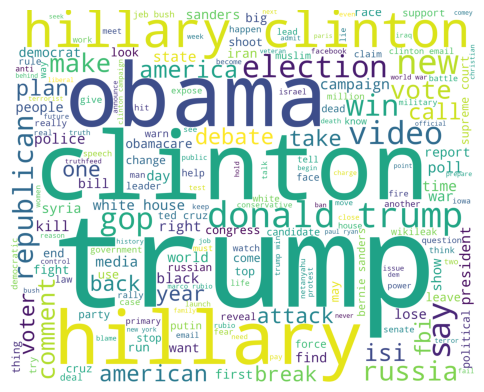

In [22]:
# Creamos imagen con las palabras del conjunto de datos 
wordcloud = text_explorer.wordcloud_draw(column = CLEAN_TEXT, background_color = "white")

Creamos ranking de las palabras más frecuentes, en particular se han seleccionado 10 palabras. Este ranking se realiza con la función creada `words_ranking` dentro de la clase `ExploreTexts` del modulo `text_preproccesing`. Tras crear el ranking se representa usando el mettodo creado `plot_bar` de la clase `Graphis` del modulo `data_explorer`. 

Esta graficas dan una idea de los temas mas relevantes en un conjunto de datos, en particular en este conjunto de datos corresponden a terminos sobre politica y nombre de politicos, ya que se trata de un conjunto de datos con noticias sobre las eleccciones de EEUU. 

In [23]:
# Ranking de palabras mas repetidas
word_rank = text_explorer.words_ranking(CLEAN_TEXT, 10)

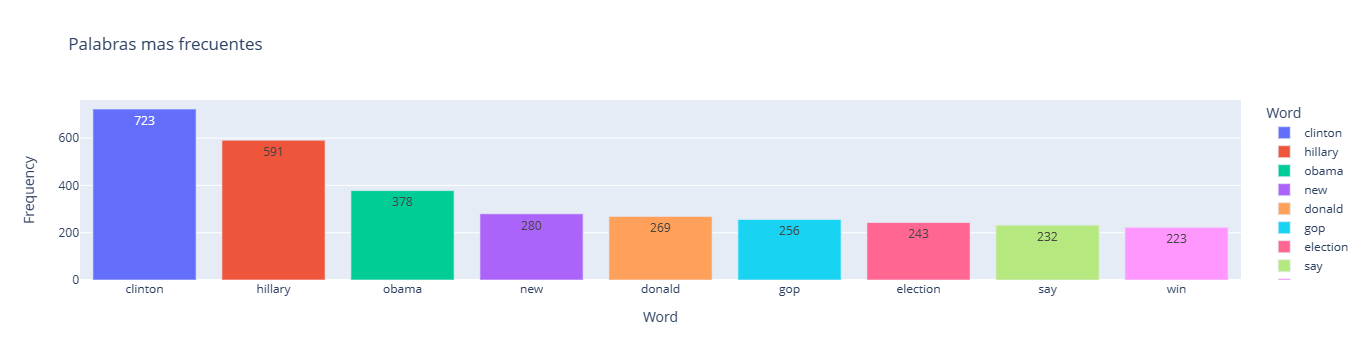

In [24]:
# Creamos grafica con las palabras del ranking
grapher = Graphics(word_rank)    # ejecutamos graficador para el df que contiene el ranking
# Representamos indicando los parametros necesarios
bar_graph_label = grapher.plot_bar(X = word_rank.columns[0], 
                                   Y = word_rank.columns[1], 
                                   title = "Palabras mas frecuentes", 
                                   decimals = ".4", 
                                   color_var = word_rank.columns[0])
# Mostramos el grafico
bar_graph_label.show()

https://plotly.com/~egctechspace/70/


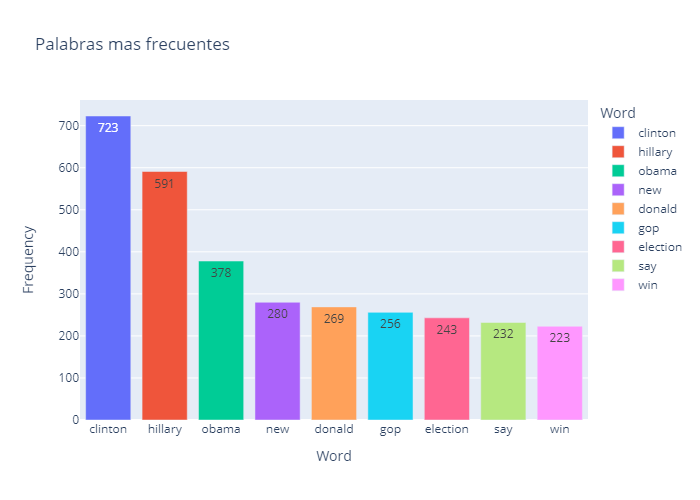

In [25]:
# Sube la figura a Chart Studio y la guarda 
save_chart(bar_graph_label, "ranking_wod_fakeNews", upload=True, ext=".png", base_path=IMAGES_PATH)

<p style="font-family: sans-serif; color:#00A2BB; font-size:150%; text-align:left; text-transform: uppercase"><b>5. Aplicacion analisis NLP: procesado del texto</b></p>

Ya se han aplicado tecnicas como lematizacion, ahora usaremos glob embeding, para lo que hemos de obtener el texto en tokens. 

In [26]:
# Para nuestro conjunto de datos definimos variables: 
X = df[CLEAN_TEXT]      # Variable independiente, Texto limpio a clasificar y con el que se entrenará
y = df[CLASS]           # Variable dependiente, classe a predecir

- **Tokenización**

Convertimos el texto a valores numericos tokens, donde cada secuencia pertenece a un registro de los datos. Todas las secuencias se completan para tener la misma longitud. La posición de los tokens no tiene relevancia, solo la aparición de estos.  El `word index` es un diccionario donde se define el valor asignado a cada palabra. Ej: {trump:1, win:3, ...}. Para ello hemos creado la clase `Tokenie` en el módulo `text_proccesing`, la cual contine funciones para la tokenizaciñón del texto. 

In [27]:
# Aplicamos tokenizacion 
tokenizer_run = Tokenize(X)     # Ejecutamos toquenizador para el texto limpio X
results_tokenizer_X = tokenizer_run.pad_sequence()    # Creamos la secuencia
word_index = tokenizer_run.get_word_index()           # Obtenemos el index 

- **Embedding**

Construimos una matriz embeding o de palabras incrustadas con las palabras de nuestro conjunto de datos. Para ello hacemos uso del método creado para este fin `embedding_matrix` de la clase `Embedding` del módulo `text_proccesing`. Tras crear la matriz rescatamos y guardamos en una variable la longitud de esta porque esta matriz será la entrada del modelo que utilizaremos y necesitamos crear el numero de unidades igual al tamaño de la matriz.  

In [28]:
# Incrustacion de palabras, Glove. 
embedder = Embeddings(PATH_GLOVE_FILE)
embedding_matrix = embedder.embedding_matrix(word_index)    # Creamos matrix 
embedding_size = embedder.get_embeddings_size()             # Obtenemos tamaño 

C:\Users\Eva González\AppData\Local\Temp\ipykernel_26196\3809983796.py:3: FutureWarning:

arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.



<p style="font-family: sans-serif; color:#00A2BB; font-size:150%; text-align:left; text-transform: uppercase"><b>6. Modelo</b></p>

<p style="font-family: sans-serif; color:#00A2BB; font-size:140%; text-align:left"><b>6.1. Arquitectura del modelo</b></p>
Creamos el modelo que aplicaremos, en particular un modelo de redes neuroles donde se inicializará una capa de embeding, a la que le seguiran capas LTSM por su memoria, ya que son capaces de recordar información a lo largo del tiempo y son especialmente útiles para problemas en los que el contexto es importante como es el analisis de texto. 

- **Modelo secuancial LSMT**

Definimos tipo de modelo y capas a utilizar. Dejaremos como parametros de la función los hiperparametros a ajustar del modelo. 

In [29]:
def create_sequential_model(recurrent_dropout_rate, lstm_units, dense_units, dropout_rate, learning_rate):
    """
    Crea un modelo secuencial utilizando capas LSTM y Dense.
    
    Argumentos:
        recurrent_dropout_rate (float): Tasa de abandono recurrente para las capas LSTM.
        lstm_units (int): Número de unidades en las capas LSTM.
        dense_units (int): Número de unidades en la capa Dense.
        dropout_rate (float): Tasa de abandono para las capas Dropout.
        learning_rate (float): Tasa de aprendizaje para el optimizador Adam.
    
    Devuelve:
        tf.keras.Sequential: Un modelo secuencial compilado y listo para entrenar.
    """
    model = tf.keras.Sequential()
    
    # Añadir una capa de incrustación para convertir las palabras en vectores
    model.add(tf.keras.layers.Embedding(len(word_index) + 1, 
                                        output_dim = embedding_size,
                                        input_length = INPUT_LENGTH,
                                        weights = [embedding_matrix],
                                        trainable = False))

    # Añadir una capa LSTM con abandono recurrente
    model.add(tf.keras.layers.LSTM(units=lstm_units,
                                   return_sequences = True,
                                   recurrent_dropout = recurrent_dropout_rate,
                                   dropout=recurrent_dropout_rate))
    
    # Añadir una capa de abandono para reducir el sobreajuste
    model.add(tf.keras.layers.Dropout(dropout_rate))

    # Añadir otra capa LSTM con abandono recurrente
    model.add(tf.keras.layers.LSTM(units = lstm_units // 2,
                                   recurrent_dropout = recurrent_dropout_rate / 2,
                                   dropout = recurrent_dropout_rate / 2))
    
    # Añadir otra capa de abandono
    model.add(tf.keras.layers.Dropout(dropout_rate))

    # Añadir una capa Dense con activación ReLU
    model.add(tf.keras.layers.Dense(units = dense_units,
                                    activation = 'relu'))

    # Añadir una capa Dense con activación sigmoide para la salida binaria
    model.add(tf.keras.layers.Dense(1,
                                    activation = 'sigmoid'))
    
    # Compilar el modelo con pérdida de entropía cruzada binaria y optimizador Adam
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss='binary_crossentropy', 
                  optimizer=optimizer, 
                  metrics=['accuracy', Precision(name='precision'), Recall(name='recall')])
    
    return model

<p style="font-family: sans-serif; color:#00A2BB; font-size:140%; text-align:left"><b>6.2. Representación métricas</b></p>

Método para la representación de graficos de lineas de las métricas, donde se compararán los valores de entrenamiento y de validación.

In [30]:
def plot_metrics(history, metrics, nx, ny, sizeX = 13, sizeY =5):
    """
    Representa las métricas de entrenamiento y validación en una cuadrícula de gráficos.
    
    Argumentos:
        history (dict): Un diccionario que contiene los valores de las métricas durante el entrenamiento.
        metrics (list): Una lista de nombres de métricas para representar.
        nx (int): Número de filas en la cuadrícula de gráficos.
        ny (int): Número de columnas en la cuadrícula de gráficos.
        sizeX (int): Ancho de la figura en pulgadas (por defecto 13).
        sizeY (int): Altura de la figura en pulgadas (por defecto 5).
    """
    # Crear una cuadrícula de gráficos
    fig, axs = plt.subplots(nx, ny, figsize = (sizeX, sizeY))
    
    # Obtener el número de épocas a partir del historial
    num_epochs = len(history[metrics[0]])
    
    # Asegurarse de que axs es una lista de listas
    if nx == 1:
        axs = [axs]
    if ny == 1:
        axs = [[ax] for ax in axs]
    
    # Representar cada métrica en un gráfico diferente
    for i in range(nx * ny):
        row = i // ny
        col = i % ny
        metric = metrics[i]
        
        # Representar los valores de entrenamiento y validación para cada métrica
        axs[row][col].plot(range(num_epochs), history[metric], label='Entrenamiento')
        axs[row][col].plot(range(num_epochs), history['val_' + metric], label='Validación')
        
        # Añadir etiquetas y título al gráfico
        axs[row][col].set_xlabel('Épocas')
        axs[row][col].set_title(metric)
        
        # Añadir leyenda al gráfico
        axs[row][col].legend()
    return fig

<p style="font-family: sans-serif; color:#00A2BB; font-size:140%; text-align:left"><b>6.3. Seleccion datos entrenamiento y prueba (Train-Test)</b></p>

Dividimos el conjutno de datos en entrenamiento y test. Notar que el conjunto de datos se divide en dos, hay una tercera partición, validación, pero esta forma parte de los datos de entrenamiento, con el ojtetivo que estos valores varien, y que el modelo se entrene sin tomar en ningun momento los datos de test para evitar que el algoritmo memorice.

In [31]:
TEST_SIZE = 0.20

In [32]:
# Datos de entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(results_tokenizer_X, y, 
                                                    test_size = TEST_SIZE,        # 20% para test
                                                    shuffle = True,          # Barajando el conjunto de datos 
                                                    random_state = 19)

<p style="font-family: sans-serif; color:#00A2BB; font-size:140%; text-align:left"><b>6.4. Modelo inicial</b></p>

Cremao sun modelo, al que le asignamos hiperparámetros habituales. Entrenamos y evaluamos este modelo. 

<p style="font-family: sans-serif; color:#00A2BB; font-size:120%; text-align:left"><b>6.4.1 Creación del modelo</b></p>

In [33]:
# Definimos variables del modelo 
INPUT_LENGTH = len(X_train[0])     # Longitud del conjunto de datos
metrics = ['accuracy', Precision(name ='precision'), Recall(name = 'recall')] 

In [34]:
# Crear modelo - indicando hiperparametros
model1 = create_sequential_model(recurrent_dropout_rate = 0.3, 
                                lstm_units = 128, 
                                dense_units = 32, 
                                dropout_rate = 0.0, 
                                learning_rate = 0.001)

# Imprimimos resumen 
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 30, 50)            396750    
                                                                 
 lstm (LSTM)                 (None, 30, 128)           91648     
                                                                 
 dropout (Dropout)           (None, 30, 128)           0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 1)                 3

<p style="font-family: sans-serif; color:#00A2BB; font-size:120%; text-align:left"><b>6.4.2 Entrenamiento del modelo</b></p>

In [35]:
# Hiperparametros de ejecucion del modelo
EPOCHS = 100   
BATCH_SIZE = 128
VALIDATION_SPLIT = 0.3

In [36]:
# Entrenamiento del modelo con los datos 
history1 = model1.fit(X_train,
                      y_train,
                      batch_size = BATCH_SIZE,
                      validation_split = VALIDATION_SPLIT,
                      epochs = EPOCHS)

Epoch 1/100
28/28 [==============================] - 9s 154ms/step - loss: 0.6507 - accuracy: 0.6343 - precision: 0.6301 - recall: 0.6835 - val_loss: 0.5928 - val_accuracy: 0.6969 - val_precision: 0.6775 - val_recall: 0.7080
Epoch 2/100
28/28 [==============================] - 3s 123ms/step - loss: 0.5906 - accuracy: 0.6966 - precision: 0.7195 - recall: 0.6630 - val_loss: 0.5707 - val_accuracy: 0.7179 - val_precision: 0.7360 - val_recall: 0.6467
Epoch 3/100
28/28 [==============================] - 3s 124ms/step - loss: 0.5657 - accuracy: 0.7186 - precision: 0.7441 - recall: 0.6823 - val_loss: 0.5525 - val_accuracy: 0.7272 - val_precision: 0.7352 - val_recall: 0.6780
Epoch 4/100
28/28 [==============================] - 3s 125ms/step - loss: 0.5576 - accuracy: 0.7116 - precision: 0.7282 - recall: 0.6923 - val_loss: 0.5687 - val_accuracy: 0.6989 - val_precision: 0.6496 - val_recall: 0.8145
Epoch 5/100
28/28 [==============================] - 3s 122ms/step - loss: 0.5428 - accuracy: 0.7257

<p style="font-family: sans-serif; color:#00A2BB; font-size:120%; text-align:left"><b>6.4.2 Evaluación del modelo</b></p>
Evaluamos como de buena fue el entreanmiento del modelo. Para ello obtenemos algunas de las metricas y representamos su evolucion en las iteraciones del modelo. 

In [37]:
# Evaluación del modelo
loss_test, accuracy_test, precision_test, recall_test = model1.evaluate(X_test, y_test)
loss_train, accuracy_train, precision_train, recall_train = model1.evaluate(X_train, y_train)

159/159 [==============================] - 1s 9ms/step - loss: 0.2458 - accuracy: 0.9384 - precision: 0.9382 - recall: 0.9390


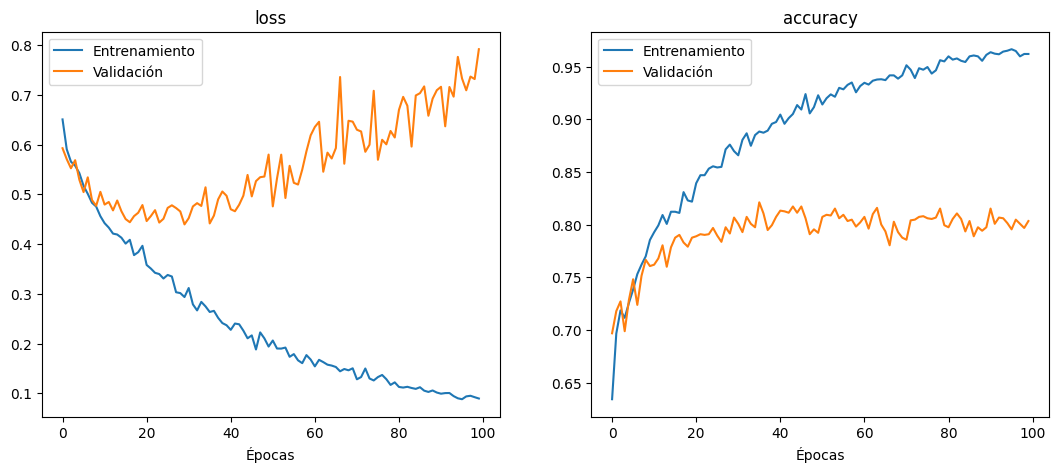

In [38]:
# Representación métrica frente epocas
plot_evaluacion_model1 = plot_metrics(history1.history, ['loss', 'accuracy'], 1, 2, sizeX = 13, sizeY =5)

<p style="font-family: sans-serif; color:#00A2BB; font-size:140%; text-align:left"><b>6.5. Ajuste de hiperparámetros</b></p>

Para mejorrar el modleo anterior haremos un ajuste de los hiperparámetros del modelo usando busqueda por cuadricula y valicdación cruzada con `GridSearchCV`.  

Creamos un diccionario con los parametros a mejorar y los posibles valores que queremos considerar. En el diccionario hemos añadido todos los hiperparametros para que sea mas sencillo añadir opciones para cada uno de ellos, pero solo buscaremos mejorar el `batch_size` y `lstm_units`. El resto al tener una sola opcion será ese el valor que obtendremos. 

In [39]:
# Cuadricula de parametros - Solo variamos los posibles valores de batch_sice y la cantidad de lstm 
param_grid = {
    'batch_size': [64, 128],
    'learning_rate': [0.001],
    'recurrent_dropout_rate': [0.3],
    'lstm_units': [64, 128],
    'dense_units': [64],
    'dropout_rate': [0.5], 
}

In [40]:
# Modelo como objeto keras para poder aplicar skalearn
model_grid = KerasClassifier(build_fn = create_sequential_model, epochs = EPOCHS, batch_size = 128, verbose = 0)

# Validación curzada 
k = 2
cv = StratifiedKFold(n_splits = k, random_state = SEED, shuffle = True)

# Aplicamos cuadrícula al modelo 
grid = GridSearchCV(estimator = model_grid, param_grid = param_grid, cv = cv)

C:\Users\Eva González\AppData\Local\Temp\ipykernel_26196\798437026.py:2: DeprecationWarning:

KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.



In [41]:
# Entrenmos el modelo cn los datos 
grid_result = grid.fit(X_train, y_train)

In [42]:
# Mejores hiperparámetros
print(f"Mejores parámetros: {grid_result.best_params_}")

Mejores parámetros: {'batch_size': 128, 'dense_units': 64, 'dropout_rate': 0.5, 'learning_rate': 0.001, 'lstm_units': 128, 'recurrent_dropout_rate': 0.3}


<p style="font-family: sans-serif; color:#00A2BB; font-size:140%; text-align:left"><b>6.6. Modelo mejorado</b></p>

A partir de los mejores parametros obtenidos realizaremos el entrenamiento de nuestro modelo. Además le añadiremos en el entrenamiento parada temprana y reducción de la tasa de aprendizaje cuando la metrica indicada no mejora.  

<p style="font-family: sans-serif; color:#00A2BB; font-size:120%; text-align:left"><b>6.6.1 Creación del modelo</b></p>

In [43]:
# Definimos variables del modelo 
INPUT_LENGTH = len(X_train[0])           # Longitud del conjunto de datos
best_params = grid_result.best_params_   # Crea un nuevo modelo con los mejores hiperparámetros encontrados
metrics = ['accuracy', Precision(name ='precision'), Recall(name = 'recall')]    # Metricas

In [44]:
# Crear modelo - indicando hiperparametros
model = create_sequential_model(recurrent_dropout_rate = best_params['recurrent_dropout_rate'],
                                learning_rate =  best_params['learning_rate'],
                                lstm_units = best_params['lstm_units'], 
                                dense_units = best_params['dense_units'], 
                                dropout_rate = best_params['dropout_rate'])
# Imprimimos resumen 
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 30, 50)            396750    
                                                                 
 lstm_20 (LSTM)              (None, 30, 128)           91648     
                                                                 
 dropout_20 (Dropout)        (None, 30, 128)           0         
                                                                 
 lstm_21 (LSTM)              (None, 64)                49408     
                                                                 
 dropout_21 (Dropout)        (None, 64)                0         
                                                                 
 dense_20 (Dense)            (None, 64)                4160      
                                                                 
 dense_21 (Dense)            (None, 1)               

<p style="font-family: sans-serif; color:#00A2BB; font-size:120%; text-align:left"><b>6.5.2 Entrenamiento del modelo</b></p>

In [45]:
# Define el callback de parada temprana
early_stopping = EarlyStopping(monitor='val_loss', patience=8) 

# Callback reducción de la tasa de aprendizaje
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

# Entrenamos el modelo 
history = model.fit(X_train, y_train, batch_size = best_params['batch_size'], 
                    epochs=EPOCHS, 
                    validation_split = VALIDATION_SPLIT, 
                    callbacks=[early_stopping, 
                               reduce_lr])

Epoch 1/100
28/28 [==============================] - 15s 292ms/step - loss: 0.6617 - accuracy: 0.6152 - precision: 0.6282 - recall: 0.5993 - val_loss: 0.5933 - val_accuracy: 0.6936 - val_precision: 0.7063 - val_recall: 0.6235 - lr: 0.0010
Epoch 2/100
28/28 [==============================] - 7s 246ms/step - loss: 0.5946 - accuracy: 0.7014 - precision: 0.7200 - recall: 0.6774 - val_loss: 0.5681 - val_accuracy: 0.7107 - val_precision: 0.6920 - val_recall: 0.7203 - lr: 0.0010
Epoch 3/100
28/28 [==============================] - 7s 250ms/step - loss: 0.5637 - accuracy: 0.7153 - precision: 0.7268 - recall: 0.7067 - val_loss: 0.5399 - val_accuracy: 0.7206 - val_precision: 0.7110 - val_recall: 0.7080 - lr: 0.0010
Epoch 4/100
28/28 [==============================] - 7s 251ms/step - loss: 0.5504 - accuracy: 0.7169 - precision: 0.7391 - recall: 0.6868 - val_loss: 0.5419 - val_accuracy: 0.7206 - val_precision: 0.6855 - val_recall: 0.7763 - lr: 0.0010
Epoch 5/100
28/28 [============================

<p style="font-family: sans-serif; color:#00A2BB; font-size:120%; text-align:left;"><b>6.5.3 Evaluación del modelo</b></p>

In [46]:
# Evaluación del modelo
loss_test, accuracy_test, precision_test, recall_test = model.evaluate(X_test, y_test)
loss_train, accuracy_train, precision_train, recall_train = model.evaluate(X_train, y_train)

159/159 [==============================] - 3s 18ms/step - loss: 0.3264 - accuracy: 0.8583 - precision: 0.8545 - recall: 0.8646


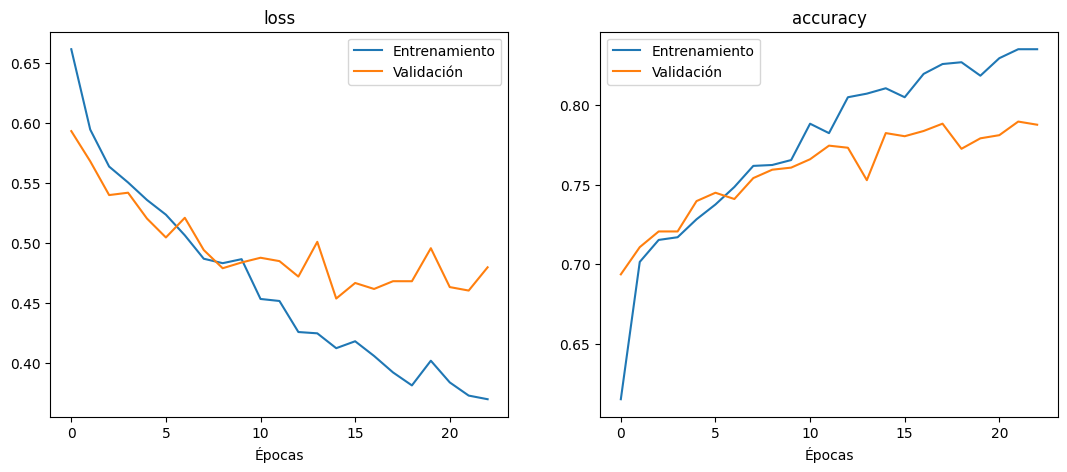

In [47]:
graph_model_evaluation = plot_metrics(history.history, ['loss', 'accuracy'], 1, 2)

C:\Users\evagonzalezcorrea\Desktop\Master\TFM\TextRecommenderNLP\PyTFMenv\lib\site-packages\plotly\matplotlylib\renderer.py:611: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



https://plotly.com/~egctechspace/78/


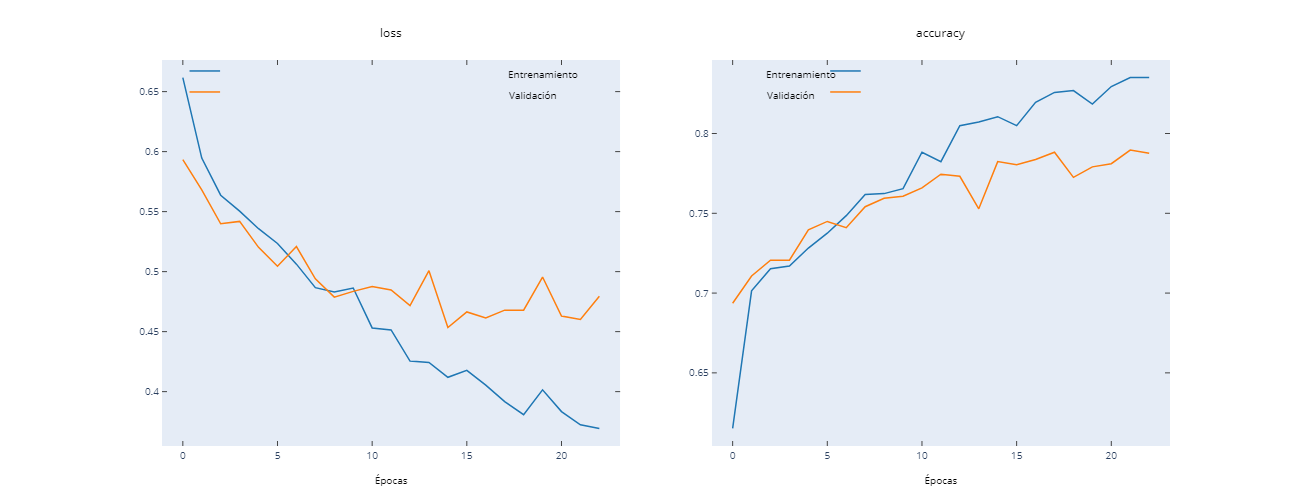

In [48]:
# Sube la figura a Chart Studio y la guarda 
import plotly.tools as tls
graph_model_evaluation_plotly =  tls.mpl_to_plotly(graph_model_evaluation)
save_chart(graph_model_evaluation_plotly, "graph_model_evaluation_FakeNews", upload=True, ext=".png", base_path=IMAGES_PATH)

<p style="font-family: sans-serif; color:#00A2BB; font-size:150%; text-align:left; text-transform: uppercase"><b>7. Resulados predicción</b></p>

Una vez tenemos el modelo, le aplicamos los datos de test para obtener la predicción. Los valores de la prediccion serán valores entre 0 y 1, donde los valores mas cercanos a cero indican que la noticia es falsa `FAKE`, mientras que si es mas cercano a 1 es verdadera `REAL`. Creamos una función que a partir de los valores de la predicción construya una lista donde los transforme a 0 y 1.
- **Conversión de la predicción a 0 o 1**

In [49]:
def result_predi_text(predictions, print_result = False):
    """
    Convierte las predicciones en 0 o 1 y opcionalmente imprime los resultados.
    
    Argumentos:
        predictions (list): Una lista de predicciones en el rango [0, 1].
        print_result (bool): Si es True, se imprimen los resultados (por defecto False).
    
    Devuelve:
        list: Una lista de resultados convertidos en 0 o 1.
    """
    # Convertir las predicciones en 0 o 1
    results = list(map(lambda x: int(x >= 0.5), predictions))
    
    # Opcionalmente imprimir los resultados
    if print_result ==True:
        for prediction, result in zip(predictions, results):
            if result:
                print(f"{prediction:.2f}: This news is True")
            else:
                print(f"{prediction:.2f}: This news is False")
    
    # Devolver los resultados
    return results

- **Calculo y representación matriz de confusión**

In [50]:
def confusion_matrix_plot(y_test, y_pred):
    """
    Representa la matriz de confusión como un mapa de calor.
    
    Argumentos:
        y_test (list): Una lista de etiquetas verdaderas.
        y_pred (list): Una lista de etiquetas predichas.
    """
    # Calcular la matriz de confusión
    confusion = confusion_matrix(y_test, y_pred)
    
    # Calcular el número total de observaciones
    total = confusion.sum()
    
    # Crear un mapa de calor de la matriz de confusión
    fig = px.imshow(confusion,
                    labels = dict(x = "Predicted", y = "Real"),
                    x = ['False', 'True'],
                    y = ['False', 'True'],
                    color_continuous_scale = 'blues')
    
    # Añadir anotaciones a cada celda de la matriz
    for i, row in enumerate(confusion):
        for j, value in enumerate(row):
            # Establecer el color de la letra según el valor de la celda
            if value > confusion.max() / 2:
                font_color = 'white'
            else:
                font_color = 'black'
            
            # Añadir anotación a la celda
            fig.add_annotation(x = j, y = i,
                               text = f"{value}\n({((value/total)*100):.2f}%)",
                               showarrow = False,
                               font = dict(color = font_color))
    
    # Añadir título al gráfico
    fig.update_layout(title = "Confusion Matrix")
    
    # Mostrar el gráfico
    fig.show()
    return fig

- **Aplicamos predicción**

In [51]:
# Prediccion. Con los valore de test (No pasados en el entrenamiento)
prediction = model.predict(X_test)

40/40 [==============================] - 1s 23ms/step


In [52]:
# Visualizacion de los 3 primeros valores
list(prediction[:3])    # Valores entre el rango 0 a 1

[array([0.624405], dtype=float32),
 array([0.06154595], dtype=float32),
 array([0.03990627], dtype=float32)]

In [53]:
# Aplicacion metodo para obtener las classes predichas
y_pred = result_predi_text(prediction)

- **Resultados**

Imprimimos las métricas obtenidas tras la predicción y la matriz de confusión que permite ver facilmente el numero de registros que fueron bien o mal clasificados. 

In [54]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.78      0.79       636
           1       0.78      0.80      0.79       631

    accuracy                           0.79      1267
   macro avg       0.79      0.79      0.79      1267
weighted avg       0.79      0.79      0.79      1267



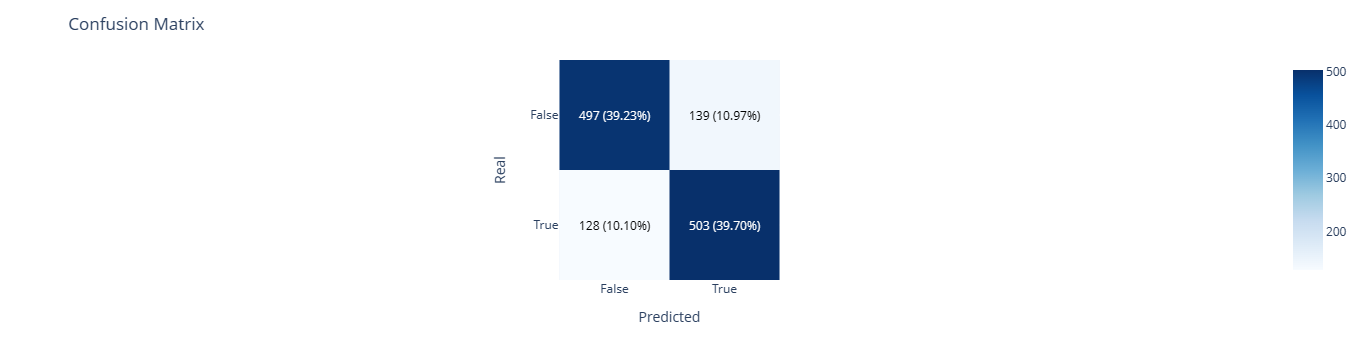

In [55]:
# Matriz de confusion. 
confusion = confusion_matrix_plot(y_test, y_pred)

https://plotly.com/~egctechspace/75/


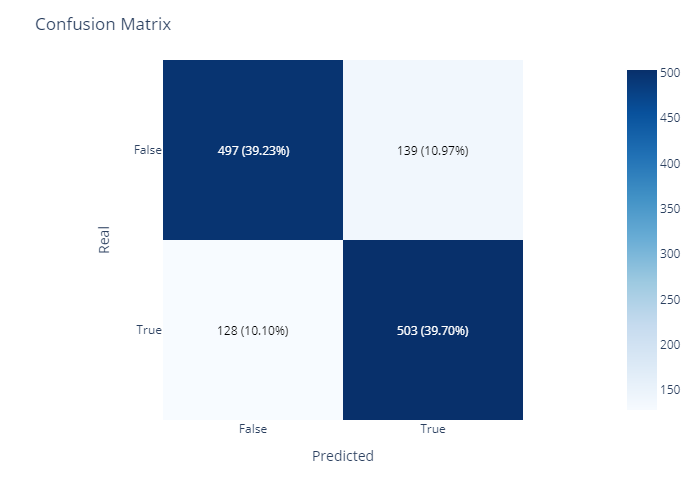

In [56]:
# Sube la figura a Chart Studio y la guarda 
save_chart(confusion, "confusionMatrix_fakeNews", upload=True, ext=".png", base_path=IMAGES_PATH)

<p style="font-family: sans-serif; color:#00A2BB; font-size:150%; text-align:left; text-transform: uppercase"><b>8. Prediccion</b></p>

Con el modelo entrenado creamos un método al cual se le pasa un texto como parametro y se realiza todo el proceso de limpieza, lematización y tokenización realizado al conjunto de datos, de forma que aplicando el modelo ya entrenado haga una predicción de la clase a la que pertenece `FAKE` o `REAL`. 

In [57]:
def predict_text(text, tokenizer_run, model):
    """
    Genera una predicción para un texto utilizando un tokenizador y un modelo.
    
    Argumentos:
        text (str): El texto para el que se desea generar una predicción.
        tokenizer_run (Tokenizer): Un tokenizador para convertir el texto en secuencias.
        model (tf.keras.Model): Un modelo entrenado para generar predicciones.
    
    Devuelve:
        float: La predicción generada por el modelo.
    """
    # Limpiar el texto
    new_text_clean = TextPreProccessing(text).clean_text()
    
    # Tokenizar y rellenar la secuencia con ceros para que tenga la misma longitud que los datos de entrenamiento
    padded_tokens = tokenizer_run.pad_sequence([new_text_clean.split()])
    
    # Generar una predicción con el modelo
    prediction = model.predict(padded_tokens)
    
    # Devolver la predicción
    return prediction[0]

In [58]:
noticia = "Kerry to go to Paris in gesture of sympathy"
pre_noticia = predict_text(noticia, tokenizer_run, model)

1/1 [==============================] - 0s 411ms/step


In [59]:
result_predi_text(pre_noticia, print_result = True)

0.45: This news is False


[0]

<p style="font-family: sans-serif; color:#00A2BB; font-size:150%; text-align:left; text-transform: uppercase"><b>9. Guardar modelos</b></p>

El modelo demonara en ser entrenado por lo que a continuación se guardan todos los procesos que mas tiempo de ejecucion llevan, con el objetivo de ser usados sin tener que ser calculados. Un ejemplo es el uso de los resultados en un dashboard. 

- **Guardar conjunto de datos procesado**

In [60]:
# Conjunto de datos pre-procesados. Guardar como archivo CSV
csv_data = df.to_csv(index=False)    # Convertir a csv

# Crea una ruta de archivo compatible con el sistema operativo
FILE_PATH_PROCESSED = os.path.join(PROJECT_PATH, 'data/processed/df_processed_fake_news.csv')

# Abre el archivo en modo escritura y guarda los datos del CSV
with open(FILE_PATH_PROCESSED, 'w', encoding='utf-8') as f:
    f.write(csv_data)
print(f'Data saved')

Data saved


- **Guardar imagen nube de palabras**

In [65]:
# Exportar imagen  WORDCLOUD
wordcloud_image = wordcloud.to_image()   # Guardar como imagen 
# Crea una ruta de archivo compatible con el sistema operativo
WORDCLOUD_PATH = os.path.join(PROJECT_PATH, 'assets/images/wordcloud_fake_News.png')
# Guarda la imagen en un archivo
wordcloud_image.save(WORDCLOUD_PATH)
print(f'Wordcloud saved')

Wordcloud saved


- **Guardar modelo entrenado**

In [66]:
# Crea una ruta de archivo compatible con el sistema operativo
MODEL_PATH = os.path.join(PROJECT_PATH, 'model/fake_news_model.h5')
# Guardar modelo entrenado
with open(MODEL_PATH, 'wb') as handle:
    model.save(MODEL_PATH)
print(f'Model saved')

Model saved


- **Guardar tokenizador entrenado**

In [67]:
# Guardar tokenizador
import pickle
# Crea una ruta de archivo compatible con el sistema operativo
TOKENIZER_PATH = os.path.join(PROJECT_PATH, 'data/processed/tokenizer.pickle')
with open(TOKENIZER_PATH, 'wb') as handle:
    pickle.dump(TOKENIZER_PATH, handle, protocol=pickle.HIGHEST_PROTOCOL)
print(f'Model saved')

Model saved
